In [1]:
# Imports
from utils import *
from sklearn.cluster import KMeans, DBSCAN
from statsmodels.stats import diagnostic
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve, r2_score
from sklearn.feature_selection import RFE
import math
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_theme()

In [2]:
# Data Imports

year_grocery = pd.read_csv("data/year_osward_grocery.csv")
display(year_grocery.head())
print(year_grocery.shape)

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E05000026,449.535137,32.5,166.4,300.0,500.0,1500.0,771.349423,3.716832,125.960833,...,37315,14370.0,7469.0,6901.0,4211.0,9421.0,738.0,29.572999,1.26,11404.761905
1,E05000027,413.130263,32.5,150.0,300.0,500.0,1500.0,626.395178,5.164174,110.664114,...,14474,10845.0,5228.0,5617.0,3205.0,6608.0,1032.0,33.568004,1.36,7974.264706
2,E05000028,407.100472,32.5,160.0,300.0,500.0,1200.0,545.890959,2.710677,121.990710,...,32138,13856.0,6750.0,7106.0,4180.0,8537.0,1139.0,32.032693,1.29,10741.085271
3,E05000029,384.173858,30.0,150.0,250.0,454.0,1500.0,591.837557,4.968373,122.245578,...,16223,10850.0,5300.0,5550.0,3023.0,6251.0,1576.0,36.004793,3.38,3210.059172
4,E05000030,356.882607,30.0,140.0,250.0,450.0,1000.0,465.284180,3.880963,109.959688,...,17522,11348.0,5515.0,5833.0,2747.0,6961.0,1640.0,37.247444,3.45,3289.275362


(638, 202)


## Preprocessing

### Filter data

We consider only 80% of the areas, the one with the highest representativeness norm 

In [3]:
# year_grocery=year_grocery.sort_values(by='representativeness_norm', ascending=False, ignore_index=True)
#year_grocery = year_grocery.nlargest(
 #   int(0.8*len(year_grocery)), 'representativeness_norm')

PERCENTAGE_SPLIT_REPRESENTATIVENESS = 0.8
N = len(year_grocery)

year_grocery = year_grocery.nlargest(
    int(PERCENTAGE_SPLIT_REPRESENTATIVENESS * N), 'representativeness_norm')

In [4]:
#Computing the nutripoints by using the function implemented
year_grocery["nutripoints"] = year_grocery.apply(calculate_nutripoints, axis=1)
year_grocery["nutripoints"].describe()

count    510.000000
mean       9.237255
std        1.469929
min        0.500000
25%        8.500000
50%        9.000000
75%       10.000000
max       14.500000
Name: nutripoints, dtype: float64

In [5]:
display(year_grocery.head())

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km,nutripoints
570,E05011117,382.039628,40.0,175.0,300.0,500.0,1000.0,363.202381,0.465398,105.990925,...,11911.0,6099.0,5812.0,1558.0,9552.0,801.0,34.867937,1.35,8822.962963,8.5
565,E05011112,398.825948,40.0,180.0,320.0,500.0,1000.0,397.149657,0.492467,107.602664,...,16365.0,8103.0,8262.0,2997.0,12218.0,1150.0,33.235625,1.30,12588.461538,8.0
246,E05000336,397.066289,40.0,180.0,300.0,500.0,1000.0,414.783419,0.608474,122.609742,...,11959.0,5764.0,6195.0,2625.0,7194.0,2140.0,40.250941,3.32,3602.108434,10.0
438,E05000605,416.199096,40.5,182.0,325.0,500.0,1200.0,506.239533,0.700727,107.997869,...,13599.0,7196.0,6403.0,2630.0,9919.0,1050.0,34.684389,1.31,10380.916031,9.0
162,E05000252,374.792470,40.0,173.7,300.0,500.0,1000.0,354.119901,0.563867,99.371843,...,12013.0,5828.0,6185.0,1709.0,8813.0,1491.0,37.502289,0.89,13497.752809,8.5


In [6]:
#Creating a dataframe with all the nutrient's weight
weight = year_grocery[["area_id"]+NUTRIENTS].copy()

In [7]:
#Computing the total nutrient's weight 
weight["weight_total"]=weight[NUTRIENTS].sum(axis=1)
display(weight)

,area_id,fibre,protein,carb,fat,salt,weight_total
570,E05011117,1.598593,5.692745,16.309391,8.715335,0.633354,32.949418
565,E05011112,1.582639,5.599176,17.197310,8.724019,0.639881,33.743025
246,E05000336,1.586666,5.358469,17.790212,8.762667,0.600154,34.098168
438,E05000605,1.624408,5.503870,17.458121,9.395772,0.631499,34.613669
162,E05000252,1.652122,5.535345,15.330560,8.949198,0.597672,32.064898
...,...,...,...,...,...,...,...
67,E05000114,1.645169,5.273701,20.586839,9.160612,0.587352,37.253673
255,E05000345,1.613219,5.167449,19.674053,9.373158,0.593232,36.421111
266,E05000356,1.700966,5.151850,18.893397,9.588215,0.539841,35.874269
4,E05000030,1.607947,5.307003,19.581403,9.381808,0.566784,36.444945


In [8]:
#Selecting the columns useful for further calculations 
list_column = ["area_id", "energy_tot", "energy_fat", "energy_saturate", "energy_sugar", "energy_protein", "energy_carb",
               "energy_fibre", "energy_alcohol", "h_nutrients_calories", "nutripoints"]
year_grocery = year_grocery.loc[:,
                                year_grocery.columns.isin(list(list_column))]
display(year_grocery.head())

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints
570,E05011117,78.438016,30.789383,34.635855,22.770981,65.237562,3.026622,1.892084,171.365266,1.608028,8.5
565,E05011112,78.516170,30.681996,36.415653,22.396706,68.789239,2.984949,1.558974,174.246039,1.589399,8.0
246,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,10.0
438,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,9.0
162,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,8.5


In [9]:
grocery_analysis = year_grocery.copy()
grocery_analysis=grocery_analysis.drop("area_id",axis=1)
display(grocery_analysis.head())
print(len(grocery_analysis.columns))

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints
570,78.438016,30.789383,34.635855,22.770981,65.237562,3.026622,1.892084,171.365266,1.608028,8.5
565,78.516170,30.681996,36.415653,22.396706,68.789239,2.984949,1.558974,174.246039,1.589399,8.0
246,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,10.0
438,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,9.0
162,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,8.5


10


## Exploratory Data Analysis

C:\Users\agath\anaconda3\envs\ada\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\agath\anaconda3\envs\ada\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\agath\anaconda3\envs\ada\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

Text(0.5, 0.98, 'Distplot for each nutrional feature')

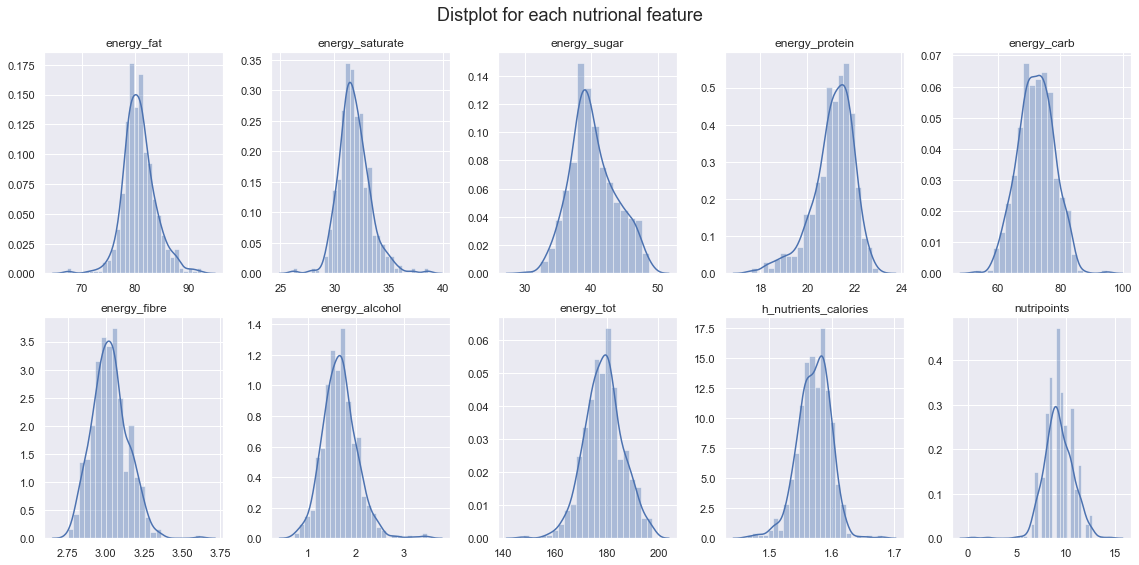

In [10]:
#Explanatory data analysis: distribution of the different variables by counting the number of observations 
fig, ax = plt.subplots(2, 5, figsize=(16, 8), sharey=False)

for i in range(len(grocery_analysis.columns)):
    sbplt = ax[int(i/5), i % 5]

    sns.distplot(grocery_analysis.iloc[:, i], ax=sbplt)
    sbplt.set_xlabel('')
    sbplt.set_ylabel('')
    sbplt.set_title(grocery_analysis.columns[i], wrap=True)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.suptitle('Distplot for each nutrional feature', fontsize=18)

C:\Users\agath\anaconda3\envs\ada\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


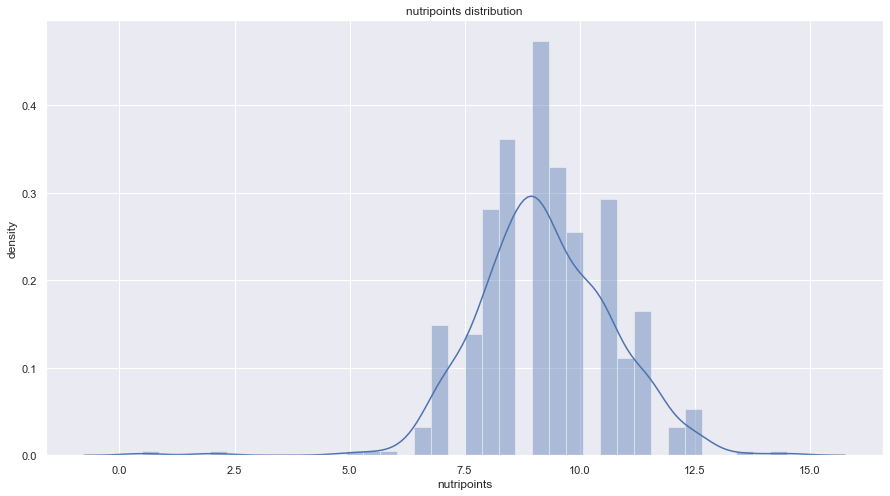

In [11]:
#Explanatory data analysis: distribution of the different variables by counting the number of observations 
plt.figure(figsize=(15,8))

sns.distplot(grocery_analysis["nutripoints"])
plt.xlabel('nutripoints')
plt.ylabel('density')
plt.title('nutripoints distribution')
plt.show();

In [12]:
#checking if nutripoints follow a normal distribution 
print(diagnostic.kstest_normal(grocery_analysis.nutripoints, dist = 'norm'))

(0.10332873411061855, 0.0009999999999998899)


Here, the p_value < 0.05 -> we can reject the null hypothesis that the nutripoints comes from a normal distribution!

<AxesSubplot:>

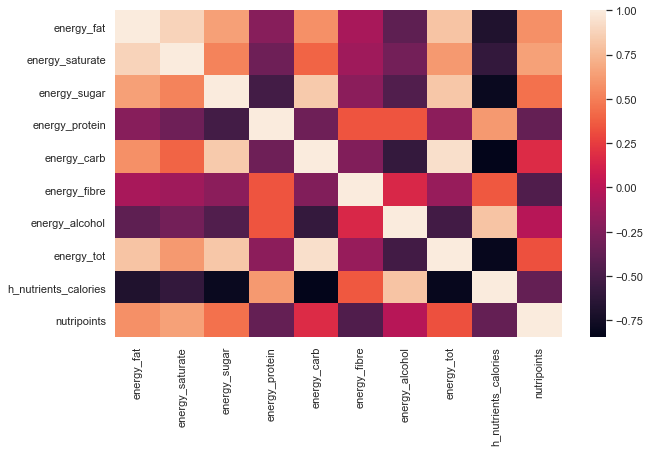

In [13]:
#Computing and plotting the correlation between the nutrients and nutriponts 
fig = plt.figure(figsize=(10, 6))
sns.heatmap(grocery_analysis.corr())

In [14]:
correlation = grocery_analysis.corr(method="spearman")
display(correlation)

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints
energy_fat,1.000000,0.823451,0.608459,-0.165126,0.585389,-0.029370,-0.365324,0.785848,-0.624390,0.517034
energy_saturate,0.823451,1.000000,0.486850,-0.225230,0.378615,-0.047231,-0.221464,0.553098,-0.465406,0.615428
energy_sugar,0.608459,0.486850,1.000000,-0.539847,0.855277,-0.270308,-0.451466,0.812268,-0.808285,0.459735
energy_protein,-0.165126,-0.225230,-0.539847,1.000000,-0.346762,0.366865,0.325737,-0.212630,0.567731,-0.370445
energy_carb,0.585389,0.378615,0.855277,-0.346762,1.000000,-0.302417,-0.598661,0.943590,-0.875802,0.254035
energy_fibre,-0.029370,-0.047231,-0.270308,0.366865,-0.302417,1.000000,0.181677,-0.196165,0.380603,-0.452051
energy_alcohol,-0.365324,-0.221464,-0.451466,0.325737,-0.598661,0.181677,1.000000,-0.530316,0.804910,-0.000041
energy_tot,0.785848,0.553098,0.812268,-0.212630,0.943590,-0.196165,-0.530316,1.000000,-0.821297,0.334266
h_nutrients_calories,-0.624390,-0.465406,-0.808285,0.567731,-0.875802,0.380603,0.804910,-0.821297,1.000000,-0.342991
nutripoints,0.517034,0.615428,0.459735,-0.370445,0.254035,-0.452051,-0.000041,0.334266,-0.342991,1.000000


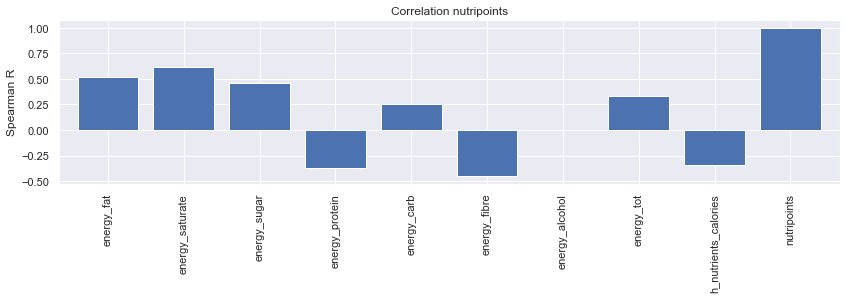

In [15]:
#Computing and plotting the correlation between the different nutrients and the nutripoints 
plt.figure(figsize=(14, 3))
correlation["nutripoints"].plot.bar(x=None, y=None, width=0.8, legend=None)
plt.ylabel("Spearman R")
plt.title("Correlation nutripoints")
plt.show()

## Machine learning: clustering

We consider only 80% of the areas, the one with the highest representativeness norm 

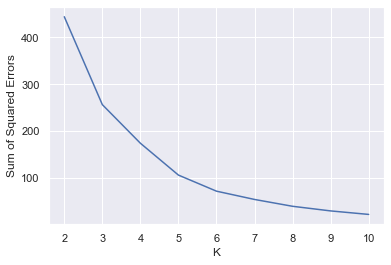

In [16]:
columns_kmeans = ['nutripoints']
grocery_kmeans = grocery_analysis[columns_kmeans].copy()

#sse score to choose k
def plot_sse(X, start=2, end=11):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(X)
        sse.append({"k": k, "sse": kmeans.inertia_})
    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")


plot_sse(grocery_kmeans)

In cluster analysis, the elbow method is used to determine the number of clusters in a data set. Here, the SSE score reaches a first low value for k=5. This number of clusters will then be used to cluster the data with K means method. 

<AxesSubplot:xlabel='nutripoints'>

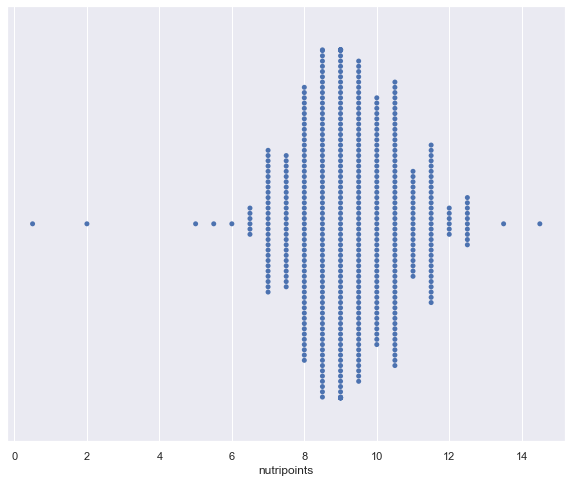

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8), sharey=True, sharex=True)

# Cluster the data with the current number of clusters
kmean = KMeans(n_clusters=5, random_state=42).fit(grocery_kmeans)

# Plot the data by using the labels as color
#axs.scatter(wellbeing_grocery_kmeans, wellbeing_grocery_kmeans, c=kmean.labels_)
grocery_kmeans['label'] = kmean.labels_
sns.swarmplot(data=grocery_kmeans, x='nutripoints',ax=axs, hue=grocery_kmeans.label)
# Plot the centroids
# for c in kmean.cluster_centers_:
#axs.scatter(c[0], c[1], marker="+", color="red")

In [18]:
#Addding a new column with the labels of the class obtained with k-means
year_grocery["nutri_class"] = kmean.labels_
year_grocery.groupby("nutri_class")["nutripoints"].min()

nutri_class
0     9.5
1     5.0
2    11.0
3     0.5
4     8.5
Name: nutripoints, dtype: float64

In [19]:
display(year_grocery)

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class
570,E05011117,78.438016,30.789383,34.635855,22.770981,65.237562,3.026622,1.892084,171.365266,1.608028,8.5,4
565,E05011112,78.516170,30.681996,36.415653,22.396706,68.789239,2.984949,1.558974,174.246039,1.589399,8.0,1
246,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,10.0,0
438,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,9.0,4
162,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,8.5,4
...,...,...,...,...,...,...,...,...,...,...,...,...
67,E05000114,82.445510,31.736518,47.351063,21.094804,82.347354,3.048458,1.509801,190.445927,1.548338,9.5,0
255,E05000345,84.358418,33.476880,45.331195,20.669797,78.696211,2.965964,1.698930,188.389319,1.550454,12.5,2
266,E05000356,86.293935,34.467013,42.264284,20.607400,75.573588,3.178303,1.352839,187.006066,1.545090,9.0,4
4,E05000030,84.436271,32.531970,45.331593,21.228013,78.325611,2.963643,1.182663,188.136201,1.540547,10.0,0


In [20]:
#Function to set a color to each label 
def addcolor(row_list):
    if row_list == 3:
        return "#038141"
    elif row_list == 1:
        return "#85BB2F"
    elif row_list == 4:
        return "#FECC02"
    elif row_list == 0:  
        return "#EE8300"
    elif row_list == 2:
        return "#E63F11"
    else: 
        return ""

      
year_grocery["color"] = year_grocery.apply(
    lambda row: addcolor(row["nutri_class"]), axis=1)
display(year_grocery)

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class,color
570,E05011117,78.438016,30.789383,34.635855,22.770981,65.237562,3.026622,1.892084,171.365266,1.608028,8.5,4,#FECC02
565,E05011112,78.516170,30.681996,36.415653,22.396706,68.789239,2.984949,1.558974,174.246039,1.589399,8.0,1,#85BB2F
246,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,10.0,0,#EE8300
438,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,9.0,4,#FECC02
162,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,8.5,4,#FECC02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,E05000114,82.445510,31.736518,47.351063,21.094804,82.347354,3.048458,1.509801,190.445927,1.548338,9.5,0,#EE8300
255,E05000345,84.358418,33.476880,45.331195,20.669797,78.696211,2.965964,1.698930,188.389319,1.550454,12.5,2,#E63F11
266,E05000356,86.293935,34.467013,42.264284,20.607400,75.573588,3.178303,1.352839,187.006066,1.545090,9.0,4,#FECC02
4,E05000030,84.436271,32.531970,45.331593,21.228013,78.325611,2.963643,1.182663,188.136201,1.540547,10.0,0,#EE8300


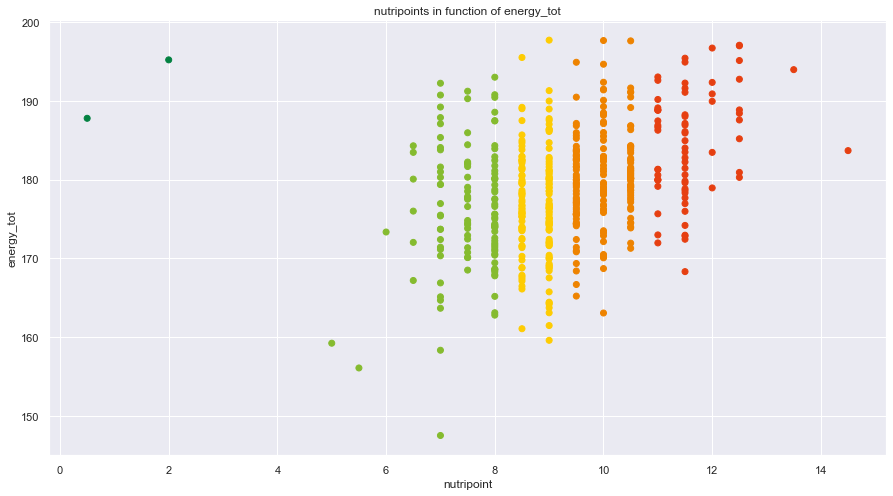

In [21]:
plt.figure(figsize=(15,8))

plt.scatter(year_grocery["nutripoints"],year_grocery["energy_tot"], c=year_grocery["color"])

plt.xlabel('nutripoint')
plt.ylabel('energy_tot')
plt.title('nutripoints in function of energy_tot')
plt.show();

## Further Exploratory after nutripoints calculation

Text(0.5, 0.98, 'Scatter plots of the different areas for food-related predictor pairs')

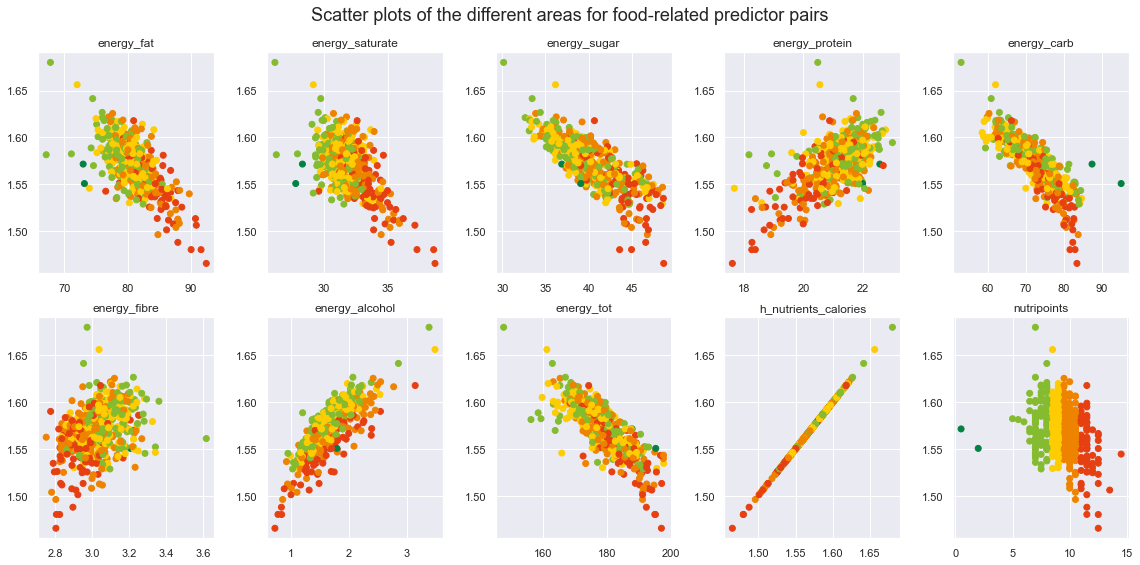

In [22]:
#Represenation of ward areas according to their values for food-related predictor pairs 
#Colors are set according to the nutri label of the area

fig, ax = plt.subplots(2, 5, figsize=(16, 8), sharey=False)

for i in range(len(grocery_analysis.columns)):
    sbplt = ax[int(i/5), i % 5]
    sbplt.scatter(grocery_analysis.iloc[:,i], grocery_analysis["h_nutrients_calories"],c=year_grocery["color"])
    sbplt.set_xlabel('')
    sbplt.set_ylabel('')
    sbplt.set_title(grocery_analysis.columns[i], wrap=True)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.suptitle('Scatter plots of the different areas for food-related predictor pairs', fontsize=18)

In [23]:
#Converting nutri labels (from 0 to 4) into letters (from A to E)
def nutri_labels_to_letter(row_list):
    if row_list == 3:
        return "A"
    elif row_list == 1:
        return "B"
    elif row_list == 4:
        return "C"
    elif row_list == 0:  
        return "D"
    elif row_list == 2:
        return "E"
    else: 
        return ""

      
year_grocery["nutrilabel"] = year_grocery.apply(
    lambda row: nutri_labels_to_letter(row["nutri_class"]), axis=1)
display(year_grocery)

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class,color,nutrilabel
570,E05011117,78.438016,30.789383,34.635855,22.770981,65.237562,3.026622,1.892084,171.365266,1.608028,8.5,4,#FECC02,C
565,E05011112,78.516170,30.681996,36.415653,22.396706,68.789239,2.984949,1.558974,174.246039,1.589399,8.0,1,#85BB2F,B
246,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,10.0,0,#EE8300,D
438,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,9.0,4,#FECC02,C
162,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,8.5,4,#FECC02,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,E05000114,82.445510,31.736518,47.351063,21.094804,82.347354,3.048458,1.509801,190.445927,1.548338,9.5,0,#EE8300,D
255,E05000345,84.358418,33.476880,45.331195,20.669797,78.696211,2.965964,1.698930,188.389319,1.550454,12.5,2,#E63F11,E
266,E05000356,86.293935,34.467013,42.264284,20.607400,75.573588,3.178303,1.352839,187.006066,1.545090,9.0,4,#FECC02,C
4,E05000030,84.436271,32.531970,45.331593,21.228013,78.325611,2.963643,1.182663,188.136201,1.540547,10.0,0,#EE8300,D


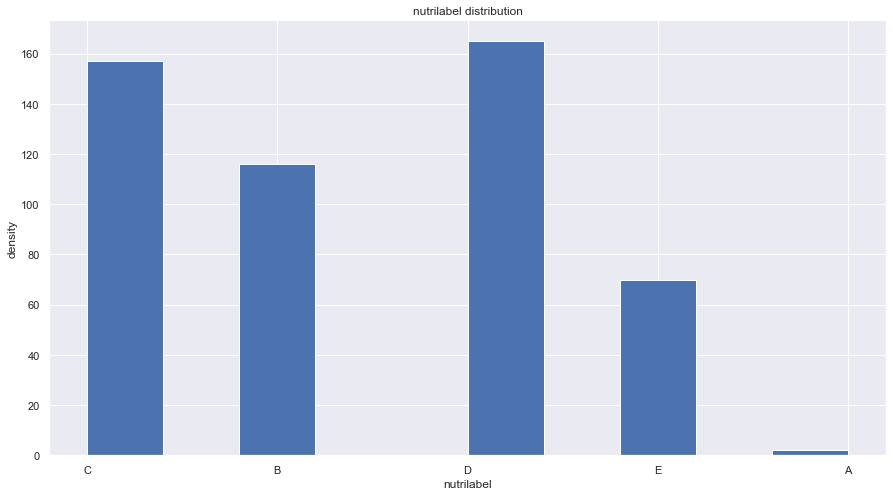

In [24]:
## REVOIR ##

plt.figure(figsize=(15,8))

#plt.bar(y_pos, height, color=['black', 'red', 'green', 'blue', 'cyan'])
#plt.xticks(y_pos, bars)
#plt.show()
height = [3, 12, 5, 18, 45]
bars = ('A', 'B', 'C', 'D', 'E')
y_pos = np.arange(len(bars))

clrs = [ "#038141","#85BB2F", "#FECC02", "#EE8300", "#E63F11"]

plt.hist(x=year_grocery["nutrilabel"])

#plt.xticks([0, 1, 2, 3, 4 ], ['A','B','C','D','E'])
#plt.xticks(y_pos, bars)
plt.xlabel('nutrilabel')
plt.ylabel('density')
plt.title('nutrilabel distribution')

plt.show();

## Typical Londonder product analysis

In [25]:
#Computing the features for typical londonner product based on the average weight of each nutrients 
weight_mean=weight.mean(axis=0)
display(weight_mean)

fibre            1.613717
protein          5.271001
carb            18.061660
fat              8.977456
salt             0.579911
weight_total    34.503744
dtype: float64

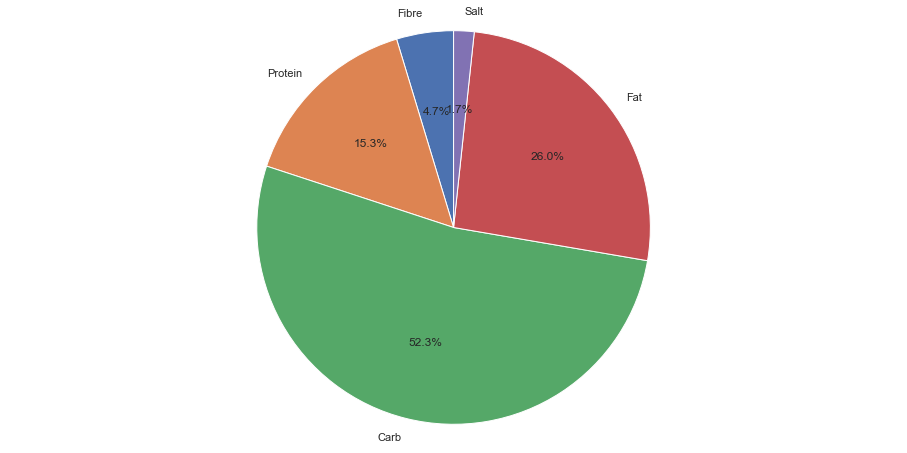

In [26]:
#Pie chart, where the slices will be ordered and plotted counter-clockwise:
nutrients_labels = ["Fibre", "Protein", "Carb", "Fat", "Salt"]
fig1, ax1 = plt.subplots(figsize=(16,8))
ax1.pie(weight_mean[0:5], labels=nutrients_labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

This pie charty visually shows the proportion of each nutrient in the average londonian product. It will be compared to recommendation for a healthy diet.   

Carbs: 45 to 65%  
Fat: 20 to 35%  
Protein:  10 to 35%   
Fibre: 14%

#https://healthyeating.sfgate.com/recommended-fats-carbohydrates-proteins-sodium-4478.html#

In [27]:
# Merge year_grocery and weight
weight_label=pd.merge(left=weight, right=year_grocery[["area_id","nutrilabel"]], left_on="area_id", right_on = "area_id")
display(weight_label[(weight_label["nutrilabel"]=="A") | (weight_label["nutrilabel"]=="B")].head(50))

,area_id,fibre,protein,carb,fat,salt,weight_total,nutrilabel
1,E05011112,1.582639,5.599176,17.197310,8.724019,0.639881,33.743025,B
7,E05000210,1.581207,5.631444,18.083605,8.627395,0.643619,34.567270,B
8,E05000051,1.668802,5.046031,16.060957,8.452983,0.563312,31.792086,B
9,E05000206,1.544885,5.398895,19.304378,8.832086,0.605215,35.685459,B
16,E05000055,1.615483,4.730159,16.188600,7.899728,0.497278,30.931248,B
18,E05011114,1.577125,5.445391,17.172070,8.696500,0.586190,33.477277,B
19,E05000288,1.613341,5.127104,17.988039,8.664252,0.567818,33.960556,B
21,E05000061,1.645453,5.394691,16.483877,8.847451,0.606041,32.977514,B
26,E05000598,1.595982,5.634996,18.545681,8.801519,0.662493,35.240671,B
30,E05000053,1.641468,4.539366,16.591355,7.456873,0.491664,30.720726,B


In [28]:
weight_label=weight_label.groupby("nutrilabel").mean()
display(weight_label)

,fibre,protein,carb,fat,salt,weight_total
nutrilabel,,,,,,
A,1.681524,5.572084,22.799060,8.117440,0.603134,38.773243
B,1.640762,5.344778,17.763447,8.773160,0.581424,34.103571
C,1.624639,5.322253,17.657515,8.896043,0.580201,34.080650
D,1.597896,5.254784,18.230168,9.058203,0.583937,34.724987
E,1.579762,5.063412,18.929730,9.332840,0.566597,35.472342


In [29]:
#fig, ax = plt.subplots(1, 5, figsize=(16, 16))

#for i in range(len(weight_label)):
  #  sbplt = ax[i]
   # sbplt.pie(weight_label.iloc[i,0:5], labels=nutrients_labels, autopct='%1.1f%%', startangle=90)
   # sbplt.axis('equal')
   # sbplt.set_title(weight_label.index[i])
#fig.tight_layout()
#fig.subplots_adjust(top=0.5)

#fig.suptitle('Pie plot for each nutrilabel', fontsize=18)